# Implémentation du schéma de Rusanov

## Importations

In [1]:
import math as math
import matplotlib.pyplot as plt

from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure

import numpy as np
import imageio

import time

## Paramètres du problème

In [31]:
g=1 # Constante gravitationnelle

N=64
h=1/(N+1) # Pas du maillage spatial

T=5 # Temps Max
t=0 # Temps dans la simulation
n=0 # Nombre d'itérations

X = np.linspace(0, 1, N+2) # Discrétisation de [0, 1]

# Tableau avec 2 lignes et N+2 colonnes : discrétisation du vecteur (h, q) en N parties + 2 aux bords
# On commence avec h = q = 1 sur tout l'ensemble étudié :

U = np.ones((2,N+2))
Uprime = np.zeros((2,N+2)) # Pour faire les calculs dans la boucle

## Conditions initiales

In [32]:
for i in range(int((N+2)/2),N+2):
    U[0,i] = .5

## Nombre de sauvegardes durant la simulation

In [33]:
nSauvegarde=200
j=0
tSauvegarde=[False for i in range(nSauvegarde)]

## Affichage des images

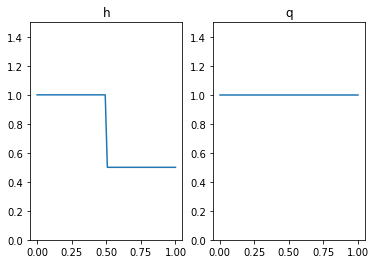

In [34]:
def affiche_U():
    
    fig, axs = plt.subplots(1,2)
    
    axs[0].plot(X,U[0,:])
    axs[0].set_title("h")
    axs[0].set_ylim([0,1.5])
    
    axs[1].plot(X,U[1,:])
    axs[1].set_title("q")
    axs[1].set_ylim([0,1.5])
    
    plt.show()
    
affiche_U()

## Sauvegarde des images

In [27]:
images=[]

def enregistre_U(n,t):

    t=round(t,4) # Troncature de t après la 4eme décimale
    
    fig, axs = plt.subplots(1,2)
    fig.suptitle("t="+str(t),fontsize=16)

    axs[0].plot(X,U[0,:])
    axs[0].set_title("h")
    axs[0].set_ylim([0,1.5])
    
    axs[1].plot(X,U[1,:])
    axs[1].set_title("q")
    axs[1].set_ylim([0,1.5])
    
  
    # To remove the huge white borders
    axs[0].margins(0)
    axs[1].margins(0)

    fig.canvas.draw()
    image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    image_from_plot = image_from_plot.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    
    images.append(image_from_plot)
    
    #Sauvegarde dans un fichier png
    #plt.savefig("etape"+str(n)+".png")
    
    plt.close()

## Fonction qui intervient dans le schéma :

In [28]:
def fonctionF(U,i,tau):
    F=[]
    F.append( U[1,i+1] - U[1,i-1] )
    F.append( ( U[1,i+1]**2 ) / U[0,i+1] + (g*U[0,i+1]**2) / 2 - ( U[1,i-1]**2 ) / U[0,i-1] - (g*U[0,i-1]**2) / 2)
    F[0] *= (tau/(2*h))
    F[1] *= (tau/(2*h))
    return(F)

# Résolution :

In [35]:
maxListe = [0 for i in range(N+2)] # Liste qui va contenir les conditions de stabilité 

enregistre_U(n,t)

while(t<T): # Tant que le temps max n'est pas atteint :

    #print("t="+str(round(t,4)))
    
    # Recherche condition de stabilité
    
    for i in range(1,N+1):
        
        maxListe[i] = abs( U[1,i]/U[0,i] + math.sqrt(g * U[0,i] ) )
        
        if ( abs( U[1,i]/U[0,i] - math.sqrt(g * U[0,i] ) ) > maxListe[i] ):
            maxListe[i] = abs( U[1,i]/U[0,i] - math.sqrt(g * U[0,i] ) )
        
        if ( abs( U[1,i+1]/U[0,i+1] + math.sqrt(g * U[0,i+1] ) ) > maxListe[i] ):
            maxListe[i] = abs( U[1,i+1]/U[0,i+1] + math.sqrt(g * U[0,i+1] ) )
    
        if ( abs( U[1,i+1]/U[0,i+1] - math.sqrt(g * U[0,i+1] ) ) > maxListe[i] ):
            maxListe[i] = abs( U[1,i+1]/U[0,i+1] - math.sqrt(g * U[0,i+1] ) )

    M = max( maxListe )
    
    # Pour assurer la stabilité, tau doit être inférieur à h/(2* max(vp))
    tau = h/(2*M)
    
    for i in range(1,N+1):
        
        F = fonctionF( U , i , tau )
       
        m1 = maxListe[i]
        m2 = maxListe[i-1]
        
        Uprime[0,i] = U[0,i] - F[0] + (tau*m1/(2*h))*(U[0,i+1]-U[0,i]) - (tau*m2/(2*h))*(U[0,i]-U[0,i-1])
        Uprime[1,i] = U[1,i] - F[1] + (tau*m1/(2*h))*(U[1,i+1]-U[1,i]) - (tau*m2/(2*h))*(U[1,i]-U[1,i-1])

    for i in range(1,N+1):
        U[0,i] = Uprime[0,i]
        U[1,i] = Uprime[1,i]
    
        Uprime[0,i] = 0
        Uprime[1,i] = 0
    
    # Conditions aux bords
    U[0,0] = U[0,1]
    U[1,0] = U[1,1]
    U[0,N+1] = U[0,N]
    U[1,N+1] = U[1,N]

    t+=tau
    n+=1
    
    if (t > T/nSauvegarde*j and (j<nSauvegarde) and (not tSauvegarde[j])):
        enregistre_U(n,t)
        #affiche_U()
        tSauvegarde[j]=True
        j+=1

print("Nombre d'itérations : " + str(n))

imageio.mimsave('movie.gif', images)
print("Gif Sauvegardé dans le dossier sous le nom : movie.gif")

Nombre d'itérations : 1377
Gif Sauvegardé dans le dossier sous le nom : movie.gif
